<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo%20GCN%20(Multizona).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Librerias

In [1]:
# Instalar PyTorch Geometric (versión Colab)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


# Cargar los datos (**La Paz, San Diego, Valledupar**)

In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("base_datos_solar_zonas_unificadas_2025.csv")

Saving base_datos_solar_zonas_unificadas_2025.csv to base_datos_solar_zonas_unificadas_2025.csv


In [3]:
import pandas as pd

df = df.drop(columns=["shortwave_radiation"])

df["time"] = pd.to_datetime(df["time"])

print("Datos preparados:")
print(df.head())

Datos preparados:
                 time  temperature_2m  wind_speed_10m  relative_humidity_2m  \
0 2025-02-01 00:00:00            25.5            23.1                    68   
1 2025-02-01 01:00:00            25.0            21.8                    69   
2 2025-02-01 02:00:00            24.6            20.3                    70   
3 2025-02-01 03:00:00            24.3            19.7                    72   
4 2025-02-01 04:00:00            23.9            18.9                    74   

   energia_solar_kWh    zona  
0                0.0  La Paz  
1                0.0  La Paz  
2                0.0  La Paz  
3                0.0  La Paz  
4                0.0  La Paz  


# **MODELO GCN**

### **¿Por qué usar un modelo GCN aquí?**

El modelo GCN no solo puede modelar secuencias temporales (como lo hicimos con La Paz), sino también puede aprovechar estructuras de grafos entre observaciones. En este caso, puedes construir un grafo secuencial por municipio, o un grafo intermunicipal, donde los nodos representan registros de diferentes zonas (municipios) conectados cronológicamente.

### **¿Qué vamos a hacer?**

Vamos a construir un GCN que tome en cuenta los datos secuenciales por municipio, manteniendo las conexiones como una cadena temporal, pero diferenciando los municipios a través de la variable `zona`.

### **¿Cómo se adapta el modelo GCN a múltiples municipios?**

1. Agrupar todos los datos de los municipios en un único dataset.
2. Codificar la variable zona como un número entero (0 = La Paz, 1 = San Diego, 2 = Valledupar).
3. Incluir zona como una variable más en la entrada (como una feature).
4. Crear un grafo secuencial donde cada fila (registro horario) es un nodo, y cada nodo se conecta al siguiente.

## Crear variables adicionales y preparar datos para el modelo

Vamos a preparar los datos paso a paso para aplicar un modelo GCN multizona.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

df = df.sort_values(by=["zona", "time"]).reset_index(drop=True)

df["hora"] = df["time"].dt.hour
df["dia"] = df["time"].dt.day
df["mes"] = df["time"].dt.month
df["dia_semana"] = df["time"].dt.dayofweek

df["energia_lag_1"] = df.groupby("zona")["energia_solar_kWh"].shift(1)
df["energia_lag_24"] = df.groupby("zona")["energia_solar_kWh"].shift(24)
df["prom_energia_3h"] = df.groupby("zona")["energia_solar_kWh"].rolling(3).mean().reset_index(0, drop=True)

df = df.dropna().reset_index(drop=True)

le = LabelEncoder()
df["zona_cod"] = le.fit_transform(df["zona"])  # La Paz=0, San Diego=1, Valledupar=2

features = [
    "temperature_2m", "wind_speed_10m", "relative_humidity_2m",
    "hora", "dia", "mes", "dia_semana",
    "energia_lag_1", "energia_lag_24", "prom_energia_3h",
    "zona_cod"
]

scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df["energia_solar_kWh"].values

print(" Datos procesados para GCN:")
print("Forma X:", X.shape)
print("Forma y:", y.shape)

 Datos procesados para GCN:
Forma X: (8568, 11)
Forma y: (8568,)


## Crear grafo secuencial y objeto Data de PyG


In [5]:
import torch
from torch_geometric.data import Data

x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)

edge_index = torch.tensor([
    [i, i+1] for i in range(len(df) - 1)
], dtype=torch.long).t().contiguous()

data = Data(x=x, y=y, edge_index=edge_index)

print(f" Nodos: {data.num_nodes}, Conexiones: {data.num_edges}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


 Nodos: 8568, Conexiones: 8567


Ya tenemos confirmación de que el grafo está correctamente construido con:

-  8568 nodos, uno por cada observación horaria de los tres municipios.
-  8567 conexiones, unidas secuencialmente (cada nodo con el siguiente).


## Definir el modelo GCN multizona y entrenarlo

Ahora vamos a definir el modelo GCN como lo hicimos antes, pero este entrenará sobre los datos de los tres municipios simultáneamente:

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

modelo_gcn = GCN(in_channels=x.shape[1], hidden_channels=64, out_channels=1)

optimizer = torch.optim.Adam(modelo_gcn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


## Entrenamiento del modelo

In [7]:
for epoch in range(1, 201):
    modelo_gcn.train()
    optimizer.zero_grad()
    pred = modelo_gcn(data.x, data.edge_index)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"🧪 Epoch {epoch}, Loss: {loss.item():.6f}")


🧪 Epoch 1, Loss: 0.020308
🧪 Epoch 20, Loss: 0.003138
🧪 Epoch 40, Loss: 0.001762
🧪 Epoch 60, Loss: 0.001064
🧪 Epoch 80, Loss: 0.000831
🧪 Epoch 100, Loss: 0.000726
🧪 Epoch 120, Loss: 0.000659
🧪 Epoch 140, Loss: 0.000604
🧪 Epoch 160, Loss: 0.000560
🧪 Epoch 180, Loss: 0.000525
🧪 Epoch 200, Loss: 0.000495


## Evaluación y métricas

Tomaremos el 20% más reciente de la serie (últimos 1713 registros) para prueba:

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

n_test = int(len(data.y) * 0.2)
y_true_gcn = data.y[-n_test:].cpu().detach().numpy().ravel()
y_pred_gcn = pred[-n_test:].cpu().detach().numpy().ravel()

rmse_gcn = np.sqrt(mean_squared_error(y_true_gcn, y_pred_gcn))
r2_gcn = r2_score(y_true_gcn, y_pred_gcn)
mae_gcn = mean_absolute_error(y_true_gcn, y_pred_gcn)

print(f"RMSE (GCN multizona): {rmse_gcn:.4f}")
print(f"R² (GCN multizona): {r2_gcn:.4f}")
print(f"MAE (GCN multizona): {mae_gcn:.4f}")

RMSE (GCN multizona): 0.0250
R² (GCN multizona): 0.9209
MAE (GCN multizona): 0.0160


## Visualización de resultados


### 6.1: Predicción vs Real

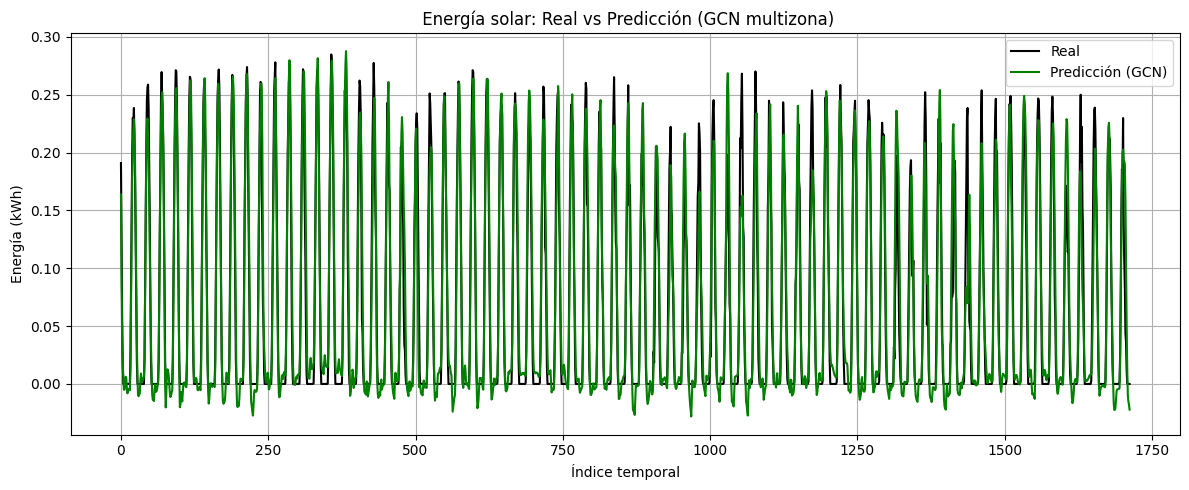

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true_gcn, label='Real', color='black')
plt.plot(y_pred_gcn, label='Predicción (GCN)', color='green')
plt.title(" Energía solar: Real vs Predicción (GCN multizona)")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.2: Dispersión predicho vs real


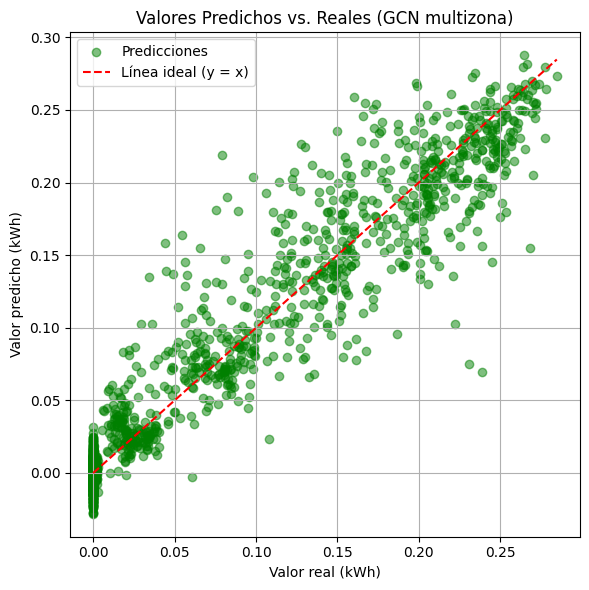

In [10]:
y_true_flat = y_true_gcn.ravel()
y_pred_flat = y_pred_gcn.ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, color='green', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat)], [0, max(y_true_flat)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GCN multizona)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
